In [11]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
directory = 'Dataset'

In [13]:
image_generator = ImageDataGenerator(rescale = 1./255)

In [19]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [20]:
train_images, train_labels = next(train_generator)
train_images.shape

(40, 256, 256, 3)

In [21]:
labels_names = {0:'Covid-19', 1: 'Normal', 2:'Pneumonia Viral', 3:'Pneumonia Bacterial'}

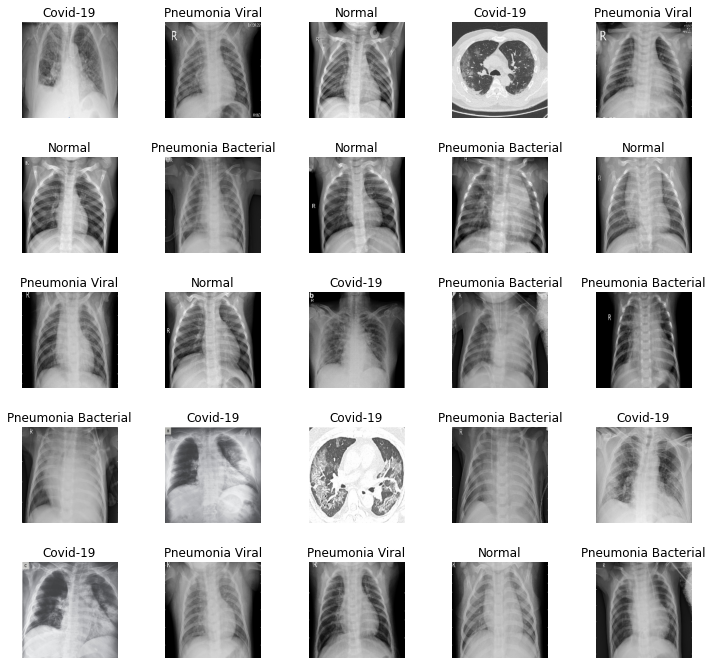

In [26]:
fig, axes = plt.subplots(5,5, figsize = (12,12))
axes = axes.ravel()
for i in np.arange(0,25):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [28]:
#Transferência de aprendizagem

base_model = ResNet50(weights='imagenet', include_top = False,
                     input_tensor = Input(shape=(256,256,3)))


94773248/94765736 [==============================] - 15s 0us/step


In [29]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
#congelando os pesos, exceto as das últimas 10 layes:
for layer in base_model.layers[:-10]:
  layers.trainable = False

In [31]:
# contruindo a rede

head_model = base_model.output
head_model = AveragePooling2D()(head_model)  #reduzindo a dimensionalidade da camada anterior
head_model = Flatten()(head_model)      # tornando a saída anterior em um vetor
head_model = Dense(256, activation = 'relu') (head_model)  # primeira camada densa
head_model = Dropout(0.2)(head_model)   #excluindo 20% para evitar o overfitting
head_model = Dense(256, activation = 'relu') (head_model)  # segunda camada densa
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu') (head_model)  # terceira camada densa
head_model = Dropout(0.2)(head_model)
head_model = Dense(4,activation = 'softmax')(head_model)    # última camada com 4 saidas utilizando a função de ativação apropriada 


In [32]:
# criando um modelo:
model = Model(inputs = base_model.input, outputs = head_model)

In [33]:
# compilando 
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [34]:
# salvando os pesos
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [35]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [37]:
#treinando
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

Epoch 1/25
133/133 [==============================] - 256s 2s/step - loss: 0.3756 - accuracy: 0.9154
Epoch 2/25
133/133 [==============================] - 282s 2s/step - loss: 0.3198 - accuracy: 0.9323
Epoch 3/25
133/133 [==============================] - 279s 2s/step - loss: 0.1907 - accuracy: 0.9549
Epoch 4/25
133/133 [==============================] - 257s 2s/step - loss: 0.1689 - accuracy: 0.9586
Epoch 5/25
133/133 [==============================] - 258s 2s/step - loss: 0.0998 - accuracy: 0.9718
Epoch 6/25
133/133 [==============================] - 254s 2s/step - loss: 0.1514 - accuracy: 0.9680
Epoch 7/25
133/133 [==============================] - 242s 2s/step - loss: 0.1124 - accuracy: 0.9793
Epoch 8/25
133/133 [==============================] - 199s 1s/step - loss: 0.0277 - accuracy: 0.9925
Epoch 9/25
133/133 [==============================] - 243s 2s/step - loss: 0.0489 - accuracy: 0.9831
Epoch 10/25
133/133 [==============================] - 244s 2s/step - loss: 0.0933 - accura

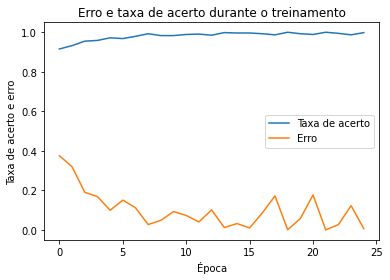

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [39]:
test_directory ='Test'

In [40]:
os.listdir(test_directory)

['3', '1', '0', '2']

In [41]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [42]:
evaluate = model.evaluate_generator(test_generator)

/home/rafael/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [44]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [45]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 3, 2, 2, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1]


In [46]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [48]:
accuracy_score(original, prediction)

0.8

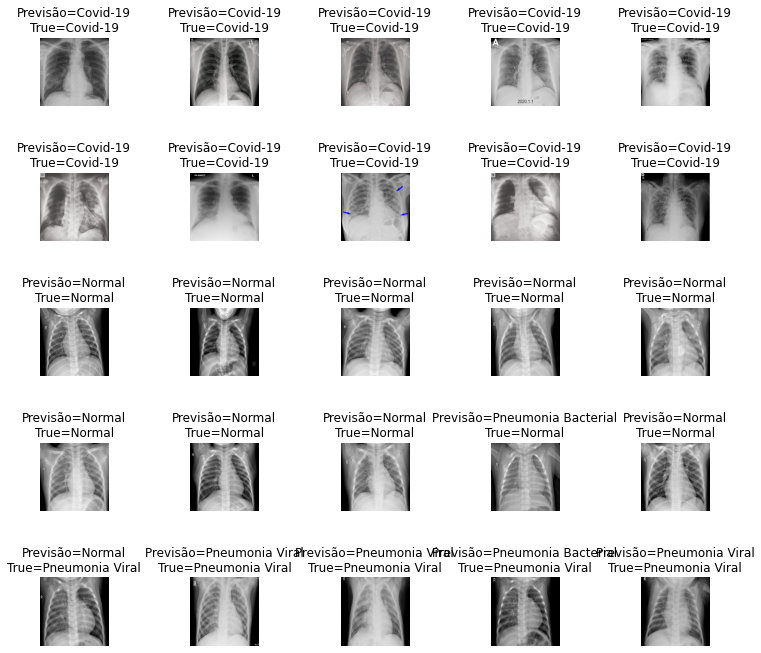

In [49]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

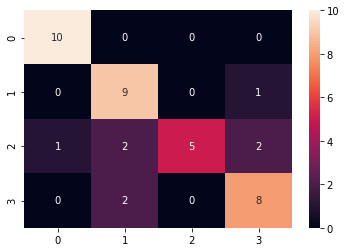

In [50]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [51]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.69      0.90      0.78        10
           2       1.00      0.50      0.67        10
           3       0.73      0.80      0.76        10

    accuracy                           0.80        40
   macro avg       0.83      0.80      0.79        40
weighted avg       0.83      0.80      0.79        40



In [54]:
#classificação de somente uma imagem
from tensorflow.keras.models import load_model
model_loaded = load_model('weights.hdf5')

In [57]:
img = cv2.imread('Test/0/1-s2.0-S0929664620300449-gr2_lrg-b.jpg')

In [ ]:
cv2.imshow('imagem', img)
cv2.waitKey(0) 
cv2.destroyAllWindows() 

In [ ]:
img = cv2.resize(img, (256, 256))

In [ ]:
img = img.reshape(-1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)

In [ ]:
predict2 = np.argmax(predict)

In [ ]:
predict2 = np.argmax(predict)